 # LDA using BOW & TF-IDF 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
import pandas as pd
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import pandas as pd

# pd.set_options("display.max_colwidth","None")
pd.set_option('display.max_colwidth', 1000)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
import calendar
cal=list(calendar.month_name)
for i in list(calendar.month_name[1:]):
    cal.append(i[:3])

In [ ]:
# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis  

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

 ##Topic Modelling: 
Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT. 

Here I am using medium article dataset to perfom Topic Modelling. The dataset consist 350 articles related to AI, Machine Learning and Data Science.

## Exploring the dataset :

In [ ]:
df_all_comments = pd.read_csv("generated_all_value_count_comments.csv")
df_all_comments.drop(columns="Unnamed: 0",axis=1,inplace=True)
df_all_comments.head()

## Exploration of text Data

Removing special characters

1.re.sub("\n","",x)-line change character to be discarded
2.re.sub("Name – Name","Name",x)
3.re.sub("Name_Name","Name",x)
4. _ with ""
5 - with ""

omitting technical values of anchors
1. omitting date of birth
2. omitting most common names
3. omitting id values
4. omitting false-hit| true-hit 
3.Unknown|false hit|False Hit.|False Hit|True Hit|True Hit.|Rationale|Source -omit them
omitting Mohd,NORAINI,ABDULLAH,BINTI,system, legal , stated , ABD,mahdzir bin khalid,siti hajar,mohd sallehudin,mohd saddam mahdzir,mahdzir khalid,inie binti abdullah,noraini,norliza binti othman
4 Numbers



Removing useless comments

1.drop - Match ID and/or Full Legal Name (doubtfull)
2.Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment|AGREED WITH MAKER RECOMMENDATION|Agreed With Maker Comments - replace with substring|agree to maker is recommendation

4.CSCDD7|CSCDD4 - Remove comments 
5CSCDD1 - remove ( still doubtful )
6 SCC6|No further review is required by analyst - remove comment
7 SC Status : No further review is required by analyst - remove comment
8 SC/DEL -remove

15 URL removal like - https://edmsfilenet.maybank.com.my/WorkplaceBFE/WcmSignIn.jsp?targetBase=https%3A%2F%2Fedmsfilenet.maybank.com.my%2FWorkplaceBFE&originPort=&originIp=172.31.75.67&targetUrl=WcmDefault.jsp
special characters - Mismatch Full Legal Name â€“ Name Does Not Sound Similar ,
16 Not removing any special character for now - Mismatch Full Legal Name_Name does not sound similar - watchperson Zhang Ping 张平 vs customer Zhang Peng 张鹏



In [ ]:
patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
# df_all_comments[df_all_comments["V_COMMENTS"].apply(lambda x: len(re.findall(patt6,x))>0)]
ind=df_all_comments[df_all_comments["V_COMMENTS"].str.extract(r"(https?://\S+|www\.\S+)")[0].apply(lambda x: pd.notna(x))].index
df_all_comments.loc[ind,"V_COMMENTS"].str.extract(r"(https?://.*\.com|www\..*\.com)").value_counts().to_csv("URL_in_comments.csv")
# 

# Pre-processing on Data

### Step -1 removing noisy data

In [ ]:
patt1=re.compile("Match ID and/or Full Legal Name",re.IGNORECASE)
# patt2=re.compile("Agreed with analyst recommendation|Agreed with analyst's recommendation|Agreed as per Maker comment|Agreed as per Maker's comment")
patt2=re.compile("(Agreed|agree) (to|with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation|is recommendation)",re.IGNORECASE)
patt3=re.compile("Unknown|false hit\.*|true hit\.*|Rationale|Source",re.IGNORECASE)
patt4=re.compile("CSCDD7|CSCDD1|CSCDD4",re.IGNORECASE)
patt5=re.compile("SCC6|No further review is required by analyst|SC/DEL",re.IGNORECASE)
patt6=re.compile("https?://\S+|www\.\S+",re.IGNORECASE)
patt7=re.compile("(%s)"%"|".join(cal)[1:],re.IGNORECASE)
patt8=re.compile("\s*(Mohd|NORAINI|ABDULLAH|BINTI|system|legal|stated|ABD|mahdzir|bin|khalid|siti|hajar|mohd|sallehudin|mohd|saddam|inie|binti|abdullah|noraini|norliza|binti|othman)\s*",re.IGNORECASE)
  

In [ ]:
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS"].apply(lambda x: re.sub("\n"," ",x)) #1

df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("Name – Name","Name",x))    #2                                
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("Name_Name","Name",x))      #3                              
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("\s*_\s*|\s*-\s*|\s*,\s*"," ",x)) #4,5


df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt1)==False] #7
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt2,"",x)) #8
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt3,"",x))  #  9
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt4)==False]        # 10
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].str.contains(patt5)==False]       #11
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt6,"",x)) #15
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("[^\w\s\.]|\d","",x)) 
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub("\d*","",x))    #date, year, accounts 6
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt7,"",x))    # month 6
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x: re.sub(patt8," ",x)) # 17



In [ ]:
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].str.lower()


In [ ]:
df_all_comments_org=df_all_comments.copy()
df_all_comments_org.to_csv("Stage_1_comments_after_pre_process.csv")

In [9]:
# df_all_comments=pd.read_csv("Stage_1_comments_after_pre_process.csv")
df_all_comments=pd.read_csv("Stage_1_comments_after_pre_process_bigram_trigram.csv")

In [10]:
df_all_comments

,Unnamed: 0,V_COMMENTS,Counts,V_COMMENTS_2
0,0,Mismatch ID number_NRIC,67150,mismatch id number nric
1,1,Mismatch ID number_NRIC\n,40137,mismatch id number nric
2,2,Mismatch Year of Birth (YOB),27341,mismatch year of birth yob
3,3,Mismatch ID Number_NRIC,25793,mismatch id number nric
4,4,Mismatch Full Legal Name – Name Does Not Sound Similar,19127,mismatch full name does not sound similar
...,...,...,...,...
221574,222058,"Mismatch - Name, NRIC, Date of birth, Profile, \n\nCustomer \nName : NORAINI BINTI ABDULLAH\nNRIC : 680709035406\nDate of birth : 09/07/1968\nProfile : SHOP SALES ASSISTANTS at MONALIZA & MASTURA S/B (COMPUTER ST (as per HOST system) \n\nWatch person - as per HOST system based on customer number 5734599)\nName : NORAINI @ INIE BINTI ABDULLAH\nNRIC : 600923125020\nDate of birth : 23/09/1960\nProfile : PEP related - Mahdzir Khalid (PEP) (spouse). Mahani Mahdzir (daughter). Siti Hajar (daughter). Mohd Sallehudin (son). Mohd Saddam Mahdzir (son).",1,mismatch name nric date of birth profile customer name nric date of birth profile shop sales assistants at monaliza mastura sb computer st as per host watch person as per host based on customer number name nric date of birth profile pep related pep spouse. mahani dhter. dhter. son. son.
221575,222059,"Mismatch - Name, NRIC, Date of birth, Profile, \n\nCustomer - (as per HOST system)\nName : NORAINI BINTI ABDULLAH\nNRIC : 710110035690\nDate of birth : 10/01/1971\nProfile : is a HOUSEWIFE/HOUSEHUSBAND - (as per HOST system) \n\nWatch person - (as per HOST system based on customer number 5734599)\nName : NORAINI @ INIE BINTI ABDULLAH\nNRIC : 600923125020\nDate of birth : 23/09/1960\nProfile : PEP related - Mahdzir Khalid (PEP) (spouse). Mahani Mahdzir (daughter). Siti Hajar (daughter). Mohd Sallehudin (son). Mohd Saddam Mahdzir (son).",1,mismatch name nric date of birth profile customer as per host name nric date of birth profile is a housewifehousehusband as per host watch person as per host based on customer number name nric date of birth profile pep related pep spouse. mahani dhter. dhter. son. son.
221576,222060,Mismatch ID number_NRIC. Watch person (NORAINI @ INIE BINTI ABDULLAH) is a Maybank customer with NRIC 600923125020 GCIF: 005734599. MAHDZIR KHALID (PEP) has transaction with her on APEX (552022018485). Customer's NRIC is 750917135656,1,mismatch id number nric. watch person is a bank customer with nric gcif . pep has transaction with her on apex . customers nric is
221577,222061,Mismatch ID number_NRIC. Watch person (NORAINI @ INIE BINTI ABDULLAH) is a Maybank customer with NRIC 600923125020 GCIF: 005734599. MAHDZIR KHALID (PEP) has transaction with her on APEX (552022018485). Customer's NRIC is 890318015980,1,mismatch id number nric. watch person is a bank customer with nric gcif . pep has transaction with her on apex . customers nric is


In [11]:
# df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].str.lower()


C:\Users\local_00147515\Temp\1\ipykernel_9972\2749681813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_comments.V_COMMENTS = df_all_comments.V_COMMENTS.apply(lambda t : t.lower())


In [ ]:
# df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"]!=""]

In [ ]:
# re.sub("Agreed with(a*) recommendation","","Agreed with recommendation")
# re.sub("Agreed (with|as per) recommendation","","Agreed recommendation")
# patt=re.compile("Agreed (with|as per) (analyst(('s)*)|maker(('s)*)) (comment|recommendation)",re.IGNORECASE)
# re.escape("analyst's")


In [ ]:
# x=re.compile("false hit\.*",re.IGNORECASE)
# re.findall(x,"false Hit.")
# txt="https://edmsfilenet.maybank.com.my/WorkplaceBFE/WcmSignIn.jsp?targetBase=https%3A%2F%2Fedmsfilenet.maybank.com.my%2FWorkplaceBFE&originPort=&originIp=172.31.75.67&targetUrl=WcmDefault.jsp"

# re.findall("https?://\S+|www\.\S+",txt)

In [ ]:
# df_all_comments[df_all_comments["V_COMMENTS"].str.contains("Mismatch Full Legal Name_Name does not sound similar - watchperson")].head(1)["V_COMMENTS"]

In [12]:
df_all_comments["V_COMMENTS_2"]
df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x : "" if pd.isna(x) else x)

C:\Users\local_00147515\Temp\1\ipykernel_9972\242794747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_comments["V_COMMENTS_2"]=df_all_comments["V_COMMENTS_2"].apply(lambda x : "" if pd.isna(x) else x)


In [13]:
df_all_comments=df_all_comments[df_all_comments["V_COMMENTS_2"].apply(lambda x : len(x)!=0)]

In [14]:
#lowercase the articles 
df_all_comments.V_COMMENTS = df_all_comments.V_COMMENTS.apply(lambda t : t.lower())

Need to check whether to remove top x count words and last y count words

**Expanding contractions:** Contractions are the shortened form of the words like it's, hasn't. We expand them for better analysis of our V_COMMENTS data. I have taken these contractions from [Analytics Vidhay's article](http://https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-V_COMMENTS-data/).

In [15]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}



In [16]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
contractions_re


re.compile(r"(ain't|'s|aren't|can't|can't've|'cause|could've|couldn't|couldn't've|didn't|doesn't|don't|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|how'd|how'd'y|how'll|I'd|I'd've|I'll|I'll've|I'm|I've|isn't|it'd|it'd've|it'll|it'll've|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|should've|shouldn't|shouldn't've|so've|that'd|that'd've|there'd|there'd've|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what've|when've|where'd|where've|who'll|who'll've|who've|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
re.UNICODE)

### Step-2 expanding contractions

In [17]:
# Function for expanding contractions
def expand_contractions(V_COMMENTS,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, V_COMMENTS)

# Expanding Contractions in the V_COMMENTS data
df_all_comments.V_COMMENTS = df_all_comments.V_COMMENTS.apply(lambda x:expand_contractions(x))

### step -3 removing stopwords 

**Removing Stopwords and Puctuations**: Stopwords are the words that are highly occurred in a language; they do not add any significance to the sentence. "a," "an," "the," "in" are some examples of stopwords. So we generally ignore stop words during our NLP task. In some NLP tasks, stop words are also important, but stopwords are unnecessary for topic modeling. We also remove punctuation marks because they are also unnecessary and do not contribute anything.

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
stop_words = set(stopwords.words('english')) 

In [20]:
def remove_stopwords(document):
    "Return the articles after remvoing stopwords"
    article_tokens = word_tokenize(document) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)

In [21]:
#removing stopwords
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x: remove_stopwords(x))

In [ ]:
# df_all_comments.V_COMMENTS_2[df_all_comments.V_COMMENTS_2.str.contains(r"\bof\b")]

### step-4 removing Punctuations

In [22]:
print(f"These are the punctuations which string.punctuation consist :  {string.punctuation}")

These are the punctuations which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [23]:
'[%s]' % re.escape(string.punctuation)

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]'

In [24]:
#removing Punctuations 
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [25]:
df_all_comments.V_COMMENTS_2

0                                                                                                                                                                                                                                                                                            mismatch id number nric
1                                                                                                                                                                                                                                                                                            mismatch id number nric
2                                                                                                                                                                                                                                                                                            mismatch year birth yob
3                                                                        

In [ ]:
# #removing digits
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(lambda x: re.sub('\d*','', x))

# df_all_comments.V_COMMENTS_2[50]

There are still some marks like quotation marks, hypen and apostrophe still remaining in the article, we also need to remove them.

In [ ]:
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(remove_extra_marks)

In [ ]:
# def remove_extra_marks(article):
#     extra_keys = ["’","—","”","“"]
#     article_tokens = word_tokenize(article) 
#     filtered_article = [word for word in article_tokens if not word in extra_keys] 
#     return " ".join(filtered_article)
    
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(remove_extra_marks)

In [ ]:
#printing arbitrary example to visulise clean data
df_all_comments.V_COMMENTS_2[50]

In [ ]:
### Step 5- Lemmatization

**Lemmaztisation:** Lemmatization process Topic modeling algorithm to avoid making mistakes by converting the word in its root from like lemmatization prevents counting "help", "helps", "helping" as three different words. Stemming can also be used, but it performs the task more forcefully, and sometimes the word loses its meaning, so I prefer lemmatization for the topic modeling task.

Here I am using **spacy** library to perform the lemmatizaton task.

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')
print(f""" "helps" after lemmztization :  {nlp("helps")[0].lemma_}""")
print(f""" "helping" after lemmztization :  {nlp("helping")[0].lemma_}""")

 "helps" after lemmztization :  help
 "helping" after lemmztization :  help


In [27]:
def lemmatize(V_COMMENTS_2):
    """Return V_COMMENTS_2 after performing the lemmitization"""
    doc = nlp(V_COMMENTS_2)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])



In [28]:
import  time
start=time.time()
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x:lemmatize(x))
end=time.time()
print(end-start)

KeyboardInterrupt: 

In [ ]:
#removing stopwords
df_all_comments.V_COMMENTS_2=df_all_comments.V_COMMENTS_2.apply(lambda x: remove_stopwords(x))

In [ ]:
df_all_comments[df_all_comments.V_COMMENTS_2.str.contains(r"\s(THE|or|be|that|to|in|and|)\s")]

In [ ]:
# df_all_comments.V_COMMENTS_3=df_all_comments.V_COMMENTS_2.copy()


In [ ]:
#lemmatize the articles
# df_all_comments.V_COMMENTS_2 = df_all_comments.V_COMMENTS_2.apply(lemmatize)

In [ ]:
df_all_comments.to_csv("comments_after_lemmatization.csv")

Now we have finished with all the data preprocessing steps, and let's plot a word cloud to visualize the most frequently used words and see the most commonly occurred word in the articles.

In [ ]:
# import wordcloud
# from wordcloud import WordCloud

# #combine all the articles
# article_data = ""
# for article in df_all_comments.V_COMMENTS_2:
#     article_data = article_data+" "+article

# #ploting the word cloud
# plt.figure(figsize=(10, 10))
# wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

## Latent Dirichlet Allocation[LDA]:  

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically. <br> 
This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

Now let's understand the work methodology of LDA using Plate Diagram:
<br>

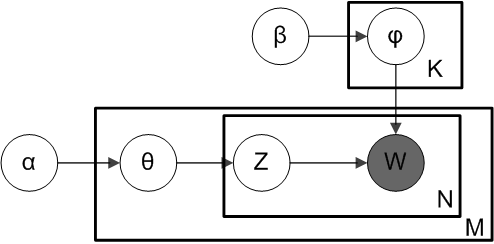
             
               **Plate Diagram of LDA model**

The above image is taken from [Wikipedia](http://https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Smoothed_LDA.png/377px-Smoothed_LDA.png)

Here, $\alpha$ and $\beta$ are two hyperparameters that we have to initialise manually, and they symbolize per topic distribution($\alpha$) and per topic word distribution($\beta$), respectively. And **Z** is the topic for the **N**-th word in document **M**, and **W** is the specific word. We can only see W(specific words) in the documents because it is only an observable variable, and all others are latent.

$\theta$ is the matrix where rows are the documents; columns are topics, and $\theta(i,j)$ represents the probability of $ith$ document containing $jth$ topic. Similarly, $\phi$ is the matrix where rows are the topics; columns are words, and $\phi(i,j)$ represents the probability of $ith$ topic containing $jth$ word. According to the distribution of $\phi$; **K** individual words are generated for the topics.

With the help of this LDA, try to estimate the words that belong to each topic and find the topics in documents accordingly.

In [ ]:
#tokenize articles
tokeize_article = df_all_comments.V_COMMENTS_2.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article) # dictionary -{id:word}

# Create Corpus
V_COMMENTS_2s = tokeize_article #

# Term Document Frequency
corpus = [id2word.doc2bow(V_COMMENTS_2) for V_COMMENTS_2 in V_COMMENTS_2s]# corpus =[(id1,feature_extraction)]


#printing 50 words from the V_COMMENTS_2 corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

In [ ]:
tokeize_article = df_all_comments.V_COMMENTS_2.apply(lambda x : x.split())

In [ ]:
df_all_comments["Tokens"]=tokeize_article
df_all_comments["id_2_feature"]=corpus

In [ ]:
# df_all_comments.drop("Corpus",axis=1,inplace=True)

In [ ]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Get the top words for each topic
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    top_words = [id2word[word_id] for word_id, prob in lda_model.get_topic_terms(topic_id, topn=10)]
    top_words_per_topic.append(top_words)

# Print the top words for each topic
# for i, top_words in enumerate(top_words_per_topic):
#     print(f"Topic {i+1}:")
#     for word, prob in top_words:
#         print(f"{word}: {prob:.4f}")
#     print()





In [ ]:
dict1={}
for i,j in zip(range(len(top_words_per_topic)),top_words_per_topic):
    dict1[i]=j

In [ ]:
dict1

In [ ]:
top_words_per_topic

In [ ]:
df_all_comments.reset_index(inplace=True)

In [ ]:
df_all_comments.drop("index",axis=1,inplace=True)

In [ ]:
# get_document_topics(corpus)
for i, doc in enumerate(corpus):
    print("Document", i+1)
    print(lda_model.get_document_topics(doc))

need to work on
1)increasing the number of topics  and no. of words in each cloud  -tuning part
2)identifying the root word - Lemmatyzing, stemming
usage of bi-grams & tri-grams
3)topic 3-pre-processing - reomval of names -Mohd,NORAINI,ABDULLAH,BINTI,
4)system, legal , stated , ABD

doubt - number ,within, SDN BHD , Pvt. Ltd. , Berhad

In [ ]:
### Visualising Topics:
# pip install pyLDAvis
# pip install gensimvis
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus, id2word)
# vis

To measure how good is our model we can use **perplexity score** and **coherence socre**. The lower score of perplexity is better for the model.

In [ ]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article,corpus=V_COMMENTS_2s, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
import pickle
pickle.dump(lda_model,open("lda_model_lemmatizer.sav","wb"))


In [ ]:
import pickle

In [ ]:
model = pickle.load(open("lda_model_lemmatizer.sav","rb"))

In [ ]:
doc_lda = model[corpus]
x=model.print_topics()
y={}
for i,j in x:
    y[i]=j
    

In [ ]:
df_all_comments["Topic"]=""
df_all_comments["All_Topic_Probabilities"]=""
df_all_comments["Topic No"]=""
for i, doc in enumerate(corpus):
      topic=sorted(model.get_document_topics(doc),key=lambda x: x[1],reverse=True)[0][0]
      df_all_comments["Topic No"].loc[i]=topic  
      df_all_comments["Topic"].loc[i]=y[topic]
      df_all_comments["All_Topic_Probabilities"].loc[i]=model.get_document_topics(doc)
#     .index(max(dict(model.get_document_topics(doc)).values()))
#      y[topic]

In [ ]:
df_all_comments["Topic words"]=df_all_comments["Topic No"].apply(lambda x: dict1[x])

In [ ]:
# df_all_comments.to_csv("Output_of_topic_modelling.csv")
# len(corpus)
# df_all_comments.loc[221574:,["V_COMMENTS_2"]]

In [ ]:
df_all_comments[df_all_comments["All_Topic_Probabilities"].apply(lambda x:type(x)==str )]["All_Topic_Probabilities"]
# model.get_document_topics(doc)

In [ ]:
df_all_comments.to_csv("Output_of_topic_modelling_only_bow.csv")

### Using tf-idf for feature extraction


In [ ]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from gensim.models import TfidfModel

In [ ]:
import numpy as np
tfidf = TfidfModel(corpus, smartirs='ntc')


In [ ]:
print(tfidf[corpus][1])
tfidf_corpus=tfidf[corpus]
# corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [ ]:
df_all_comments["TFIDF_Feature"]=[doc for doc in tfidf_corpus]

In [ ]:
df_all_comments

In [ ]:
# model using tfidf
# build LDA model for 10 topic
lda_tfidf_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [ ]:
lda_tfidf_model

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_tfidf_model.print_topics())
# doc_lda = lda_tfidf_model[corpus]

In [ ]:
# get_document_topics(corpus)
for i, doc in enumerate(tfidf_corpus):
    print("Document", i+1)
    print(lda_tfidf_model.get_document_topics(doc))

In [ ]:
import pickle
pickle.dump(lda_tfidf_model,open("lda_model_tfidf_lemmatizer.sav","wb"))


In [ ]:
model = pickle.load(open("lda_model_tfidf_lemmatizer.sav","rb"))

In [ ]:
top_words_per_topic = []
for topic_id in range(lda_tfidf_model.num_topics):
    top_words = [id2word[word_id] for word_id, prob in lda_tfidf_model.get_topic_terms(topic_id, topn=10)]
    top_words_per_topic.append(top_words)

In [ ]:
dict2={}
for i,j in zip(range(len(top_words_per_topic)),top_words_per_topic):
    dict2[i]=j

This notebook is mainly focused on LDA implementation for coherence score you can read this [medium article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

In [ ]:
# doc_lda = model[corpus]
x=model.print_topics()
y={}
for i,j in x:
    y[i]=j
    

In [ ]:
df_all_comments["Topic_tfidf_lda"]=""
df_all_comments["All_Topic_tfidf_Probabilities"]=""
df_all_comments["TF_tfidf_Topic_No"]=""
for i, doc in enumerate(corpus):
      topic=sorted(model.get_document_topics(doc),key=lambda x: x[1],reverse=True)[0][0]
      df_all_comments["TF_tfidf_Topic_No"].loc[i]=topic  
      df_all_comments["Topic_tfidf_lda"].loc[i]=y[topic]
      df_all_comments["All_Topic_tfidf_Probabilities"].loc[i]=model.get_document_topics(doc)
#     .index(max(dict(model.get_document_topics(doc)).values()))
#      y[topic]

In [ ]:
df_all_comments[" TF IDF Topic words"]=df_all_comments["TF_tfidf_Topic_No"].apply(lambda x: dict2[x])

In [ ]:
df_all_comments

In [ ]:
df_all_comments.to_csv("Output_of_topic_modelling_bow_tfidf.csv")

In [ ]:


# Get feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Print TF-IDF vectors
# print(tfidf_matrix.toarray())

# Print feature names
print(len(feature_names))
print(feature_names[:900])


### Tuning hyperparameters:

We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article,corpus=V_COMMENTS_2s, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")
            
n = 14
alpha = 0.3
beta = "auto"
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, V_COMMENTS_2s=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

Final LDA Model :